In [1]:
# reloads all sourced file before running called functions; avoids having to restart kernel for every modification
%load_ext autoreload
%autoreload 2

# autocompletion
%config Completer.use_jedi = False

In [2]:
PATH = '/'
DATA_PATH = ''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import os
import pickle
import sys
sys.path.append('../')

from torch_nn import NeuralNetwork, NetworkLearner
from miscellanea import plot_binned
from gmm_utils import plot_1D_cutoffs, plot_1D_statistics_cutoffs
from muons_utils import MuonFeatures, TempQRSimulator, plot_waldo_predictions
from qr_algorithms.complete_list import classifier_cde_dict
from qr_utils.qr_functions import train_qr_algo

In [55]:
confidence_level = 0.95
restricted = False

# Data

#### Simulated data

In [5]:
with open(os.path.join(DATA_PATH, 'training_hl_inp.pickle'), 'rb') as f:
    training_data_inp = pickle.load(f)
with open(os.path.join(DATA_PATH, 'training_hl_trg.pickle'), 'rb') as f:
    training_data_trg = pickle.load(f)
training_data_trg.shape, training_data_inp.shape

((862085,), (862085, 28))

In [6]:
simulated_data = np.hstack((training_data_inp, training_data_trg.reshape(-1, 1)))
simulated_data.shape

(862085, 29)

#### Observed data

Actually, other simulated data to be used as observed data

In [7]:
with open(os.path.join(DATA_PATH, 'validation_inp.pickle'), 'rb') as f:
    validation_inp = pickle.load(f)
with open(os.path.join(DATA_PATH, 'validation_trg.pickle'), 'rb') as f:
    validation_trg = pickle.load(f)

In [8]:
observed_data = np.hstack((validation_inp, validation_trg.reshape(-1, 1)))
observed_data.shape

(24631, 29)

#### Simulator

In [9]:
if restricted:
    simulator = MuonFeatures(param_grid_bounds=(50, 5000), 
                             param_grid_size=10_000, 
                             simulated_data=simulated_data, observed_data=observed_data,
                             observed_d=28, param_d=1, 
                             param_column=-1)
else:
    simulator = MuonFeatures(param_grid_bounds=(50, 8000), 
                             param_grid_size=10_000, 
                             simulated_data=simulated_data, observed_data=observed_data,
                             observed_d=28, param_d=1, 
                             param_column=-1)
simulator.split_simulated_data(calibration_size=0.2)

In [10]:
print('B sample: ', (simulator.b_sample_theta.shape, simulator.b_sample_x.shape))
print("B' sample: ", (simulator.b_prime_sample_theta.shape, simulator.b_prime_sample_x.shape))

B sample:  ((689668,), (689668, 28))
B' sample:  ((172417,), (172417, 28))


In [11]:
simulated_data.shape

(862085, 29)

# Test Statistics

### Conditional Mean

#### Choose model

###### XGB

In [23]:
xgb_search_params = {
    'n_estimators': [100, 500],
    'reg_lambda': uniform(loc=0, scale=10),
    'max_depth': [2, 5, 10]
}

xgb_rnd_search = RandomizedSearchCV(estimator=XGBRegressor(objective='reg:squarederror', tree_method="hist"), param_distributions=xgb_search_params, 
                                    n_iter=10, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
xgb_rnd_search.fit(X=simulator.b_sample_x, y=simulator.b_sample_theta)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monot...
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
    

In [24]:
xgb_rnd_search.best_params_, -1*xgb_rnd_search.best_score_

({'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 1.720329754456279},
 1529.3996826171874)

###### RF

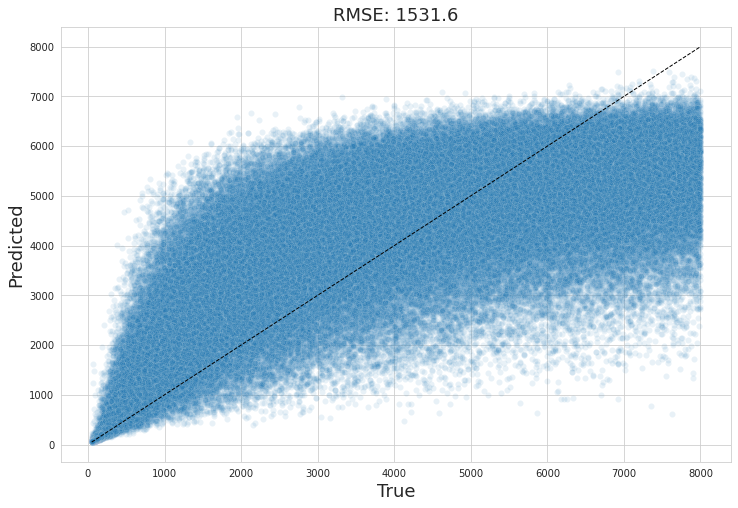

In [31]:
### TAKES TOO LONG ###
#rf_search_params = {
#    'n_estimators': [100, 200], # [100, 200, 500],
#    'max_depth': [5, 10, 20], # [2, 5, 10, 20]
#    'max_features': [0.3, 0.5, 0.7],
#}
#
#rf_rnd_search = RandomizedSearchCV(estimator=RandomForestRegressor(criterion='mse', n_jobs=-1), 
#                                   param_distributions=rf_search_params, 
#                                   n_iter=3, scoring='neg_root_mean_squared_error', cv=5, verbose=2)
#rf_rnd_search.fit(X=simulator.b_sample_x, y=simulator.b_sample_theta)


### VALIDATION ONLY ###
rf_choose = RandomForestRegressor(criterion='mse', n_jobs=-1, max_features=0.3, n_estimators=200)
rf_choose.fit(X=simulator.b_sample_x, y=simulator.b_sample_theta)
plot_waldo_predictions(x=None, y=simulator.b_prime_sample_theta, prediction=rf_choose.predict(X=simulator.b_prime_sample_x), which_prediction='Conditional mean', observed_d=simulator.observed_d)

###### Neural Network

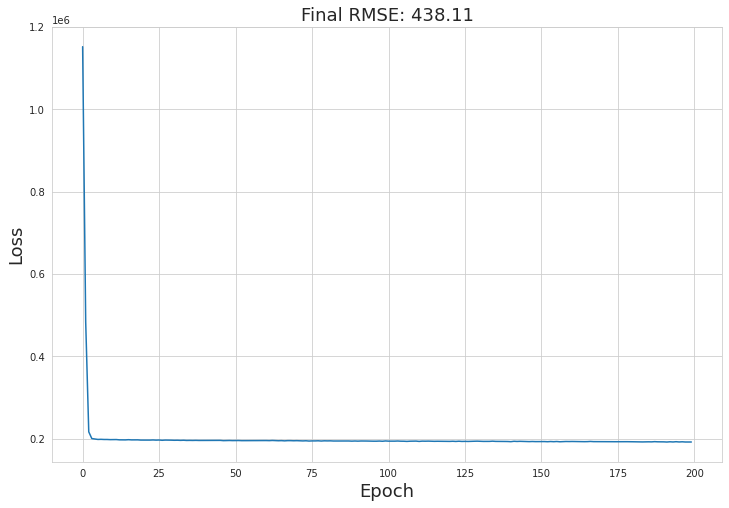

In [34]:
net_architecture = NeuralNetwork(input_size=simulator.observed_d, output_size=1, 
                                 hidden_layers=(128, 128, 64), 
                                 hidden_activation='relu', output_activation='linear', 
                                 dropout_p=0.5)

learner = NetworkLearner(model=net_architecture, optimizer='adam', loss='mse', device='cuda')
learner.fit(X=simulator.b_sample_x, y=simulator.b_sample_theta, epochs=200, batch_size=200)
learner.plot_epoch_loss()

In [ ]:
learner.

#### Final model

In [12]:
conditional_mean = XGBRegressor(objective='reg:squarederror', tree_method="hist", n_estimators=100, max_depth=5, reg_lambda=1.720329754456279)
conditional_mean.fit(simulator.b_sample_x, simulator.b_sample_theta)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1.720329754456279, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)

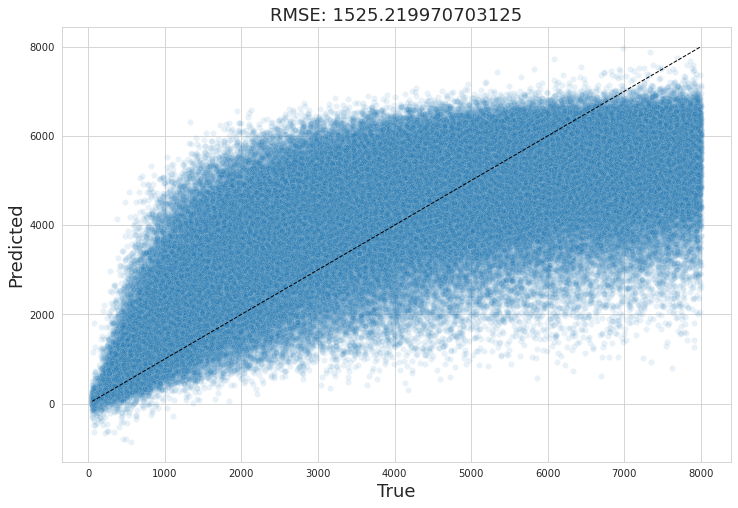

In [13]:
oos_conditional_mean = conditional_mean.predict(X=simulator.b_prime_sample_x)
plot_waldo_predictions(x=None, y=simulator.b_prime_sample_theta, prediction=oos_conditional_mean, which_prediction='Conditional mean', observed_d=simulator.observed_d)

### Conditional Variance

In [14]:
conditional_var_response = ((simulator.b_sample_theta.reshape(-1,1) - conditional_mean.predict(X=simulator.b_sample_x).reshape(-1,1))**2).reshape(-1,)

#### Choose model

###### XGB

In [37]:
xgb_search_params = {
    'n_estimators': [100, 200, 500],
    'reg_lambda': uniform(loc=0, scale=10),
    'max_depth': [2, 5, 10]
}

xgb_rnd_search = RandomizedSearchCV(estimator=XGBRegressor(objective='reg:squarederror', tree_method="hist"), param_distributions=xgb_search_params, 
                                    n_iter=10, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
xgb_rnd_search.fit(X=simulator.b_sample_x, y=conditional_var_response)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monot...
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
    

In [38]:
xgb_rnd_search.best_params_, -1*xgb_rnd_search.best_score_

({'max_depth': 2, 'n_estimators': 500, 'reg_lambda': 7.076817889597688},
 3093711.65)

###### RF

In [25]:
rf_search_params = {
    'n_estimators': [500], # [100, 200, 500],
    'max_depth': [20], # [2, 5, 10, 20]
    'max_features': [0.3, 0.5, 0.7],
}

rf_rnd_search = RandomizedSearchCV(estimator=RandomForestRegressor(criterion='mse'), 
                                   param_distributions=rf_search_params, 
                                   n_iter=3, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
rf_rnd_search.fit(X=simulator.b_sample_x, y=conditional_var_response)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/home/azureuser/miniconda3/envs/waldo-deep-muon/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
rf_rnd_search.best_params_, -1*rf_rnd_search.best_score_

It was ~415

###### Neural Network

Training NN: 100%|██████████| 200/200 [18:40<00:00,  5.60s/it]


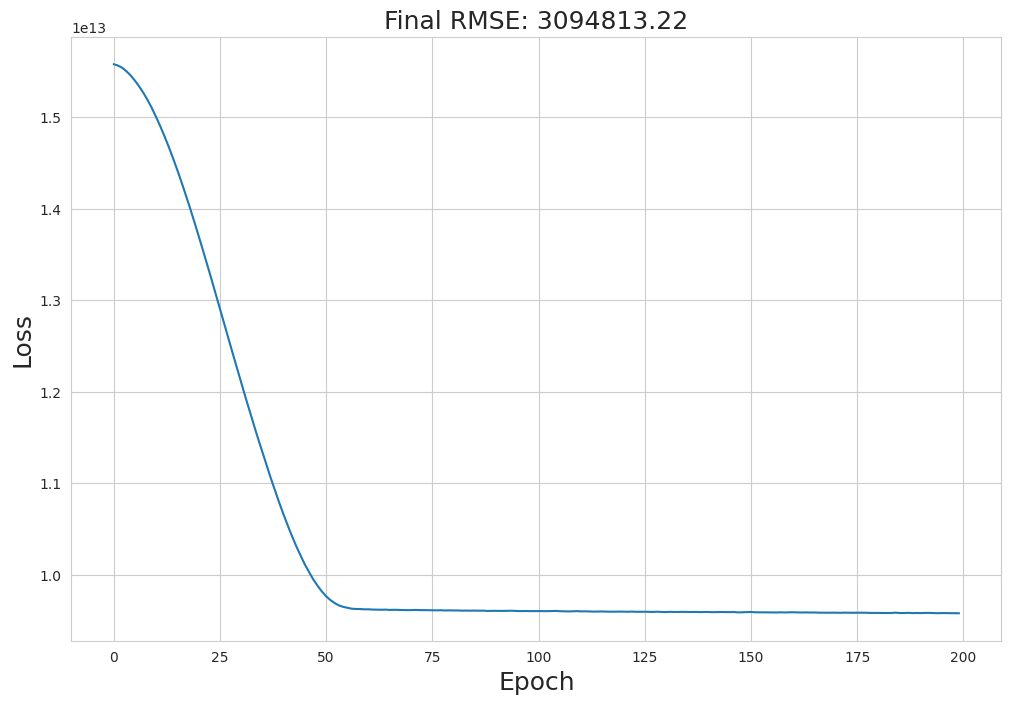

In [99]:
net_architecture = NeuralNetwork(input_size=simulator.observed_d, output_size=1, 
                                 hidden_layers=(64, 64), 
                                 hidden_activation='relu', output_activation='linear', 
                                 dropout_p=0)

conditional_var = NetworkLearner(model=net_architecture, optimizer='adam', loss='mse', device='cuda')
conditional_var.fit(X=simulator.b_sample_x, y=conditional_var_response, epochs=200, batch_size=200)
conditional_var.plot_epoch_loss()

#### Final model

In [15]:
conditional_var = XGBRegressor(objective='reg:squarederror', tree_method="hist", n_estimators=500, reg_lambda=7.076817889597688, max_depth=2)
conditional_var.fit(simulator.b_sample_x, conditional_var_response)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=7.076817889597688, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)

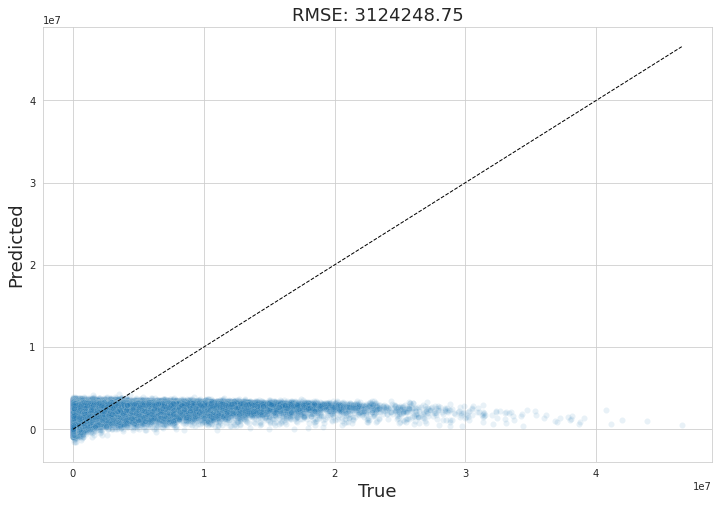

In [16]:
oos_conditional_var = conditional_var.predict(X=simulator.b_prime_sample_x)
trueish_conditional_var = ((simulator.b_prime_sample_theta.reshape(-1,1) - oos_conditional_mean.reshape(-1,1))**2).reshape(-1,)
plot_waldo_predictions(x=None, y=trueish_conditional_var, prediction=oos_conditional_var.reshape(-1, ), which_prediction='Conditional var', observed_d=simulator.observed_d)

# Critical Values

In [36]:
qr_conditional_means = conditional_mean.predict(X=simulator.b_prime_sample_x.reshape(-1, simulator.observed_d)).reshape(-1, )
qr_conditional_vars = conditional_var.predict(X=simulator.b_prime_sample_x.reshape(-1, simulator.observed_d)).reshape(-1, )

#### VAR

In [37]:
qr_statistics = ((qr_conditional_means.reshape(-1,1) - simulator.b_prime_sample_theta.reshape(-1,1))**2)/qr_conditional_vars.reshape(-1,1)
qr_statistics.shape

(172417, 1)

In [56]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB, predicted_cutoffs_xgb = train_qr_algo(model_obj=simulator, alpha=confidence_level,
                                              theta_mat=simulator.b_prime_sample_theta, stats_mat=qr_statistics,
                                              algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                              prediction_grid=simulator.param_grid)

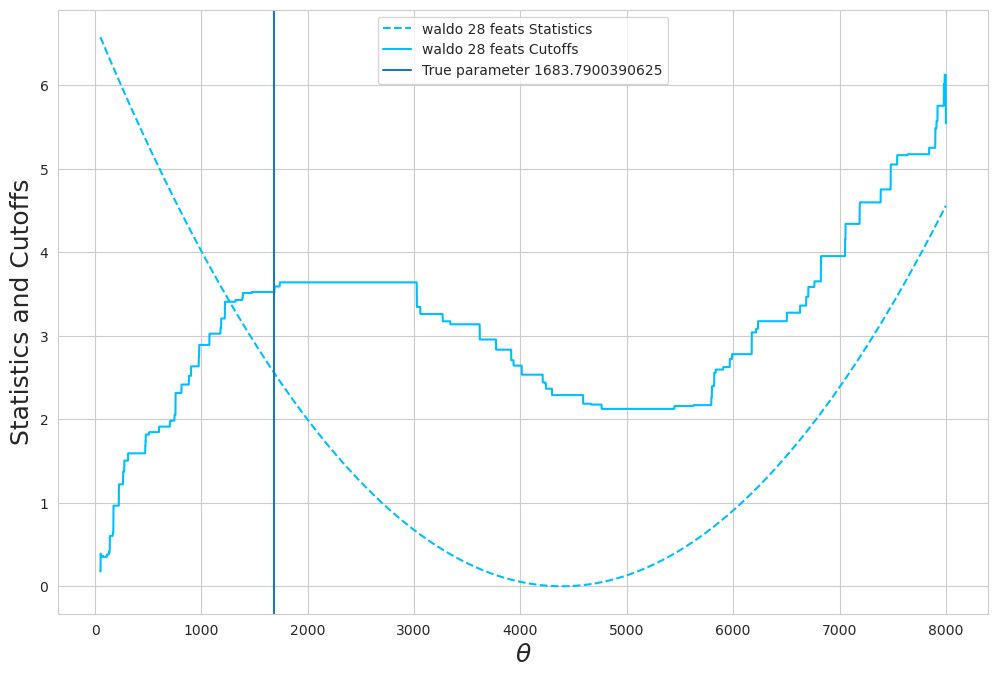

In [57]:
# plot_1D_cutoffs(parameters=simulator.param_grid, predicted_cutoffs={'28 feats full waldo': predicted_cutoffs_xgb})
idx_obs = 5000

plot_1D_statistics_cutoffs(parameters=simulator.param_grid, 
                           stats_cutoffs={'waldo 28 feats': (observed_statistics[np.argsort(observed_theta), :][idx_obs, :], predicted_cutoffs_xgb)}, 
                           true_param=np.sort(observed_theta)[idx_obs],
                           figsize=(12, 8), dpi=300, scale='linear', save_path=None)

#### NOVAR

In [20]:
qr_statistics_novar = (qr_conditional_means.reshape(-1,1) - simulator.b_prime_sample_theta.reshape(-1,1))**2
qr_statistics_novar.shape

(172417, 1)

In [58]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB_novar, predicted_cutoffs_xgb_novar = train_qr_algo(model_obj=simulator, alpha=confidence_level,
                                                          theta_mat=simulator.b_prime_sample_theta, stats_mat=qr_statistics_novar,
                                                          algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                                          prediction_grid=simulator.param_grid)

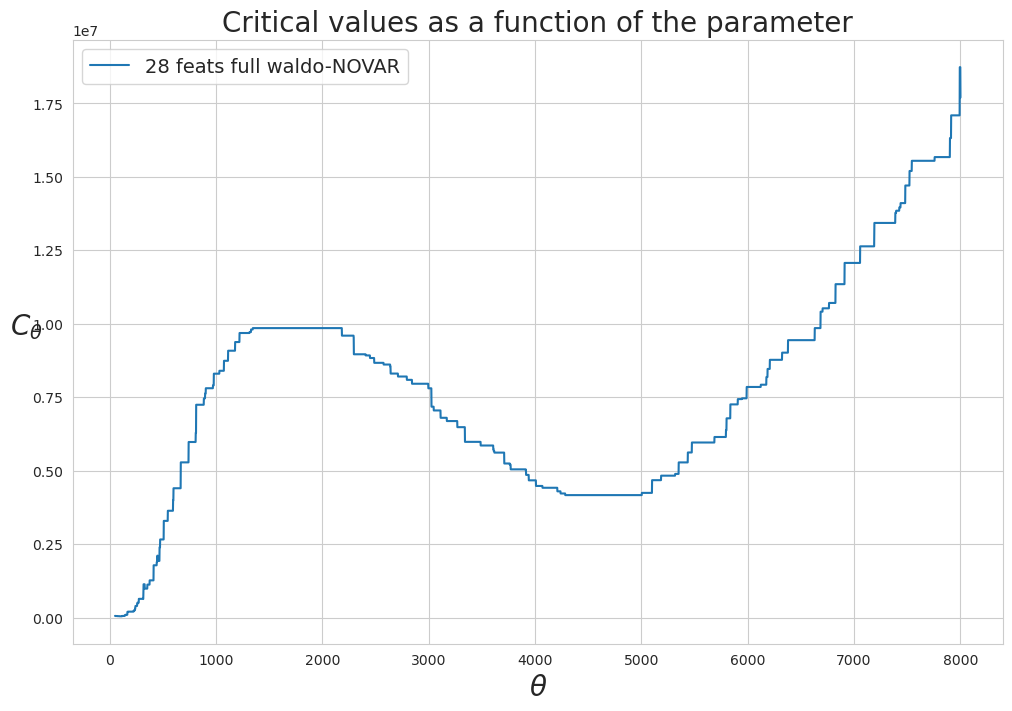

In [59]:
plot_1D_cutoffs(parameters=simulator.param_grid, predicted_cutoffs={'28 feats full waldo-NOVAR': predicted_cutoffs_xgb_novar})

# Confidence Sets

In [23]:
if restricted:
    observed_theta, observed_x = simulator.observed_data[:, -1], simulator.observed_data[:, :-1]
    observed_x = observed_x[observed_theta <= 5000, :]
    observed_theta = observed_theta[observed_theta <= 5000]
else:
    observed_theta, observed_x = simulator.observed_data[:, -1], simulator.observed_data[:, :-1]

observed_theta.shape, observed_x.shape

((24631,), (24631, 28))

In [71]:
obs_conditional_means = conditional_mean.predict(X=observed_x)
obs_conditional_vars = conditional_var.predict(X=observed_x)
# obs_conditional_vars[obs_conditional_vars < 0] = 1e-6

tile_param_grid = np.tile(simulator.param_grid, observed_x.shape[0]).reshape(observed_x.shape[0], simulator.param_grid_size)

#### VAR

In [61]:
observed_statistics = (np.subtract(obs_conditional_means.reshape(-1,1), tile_param_grid)**2)/obs_conditional_vars.reshape(-1, 1)

In [62]:
which_param = observed_statistics <= predicted_cutoffs_xgb.reshape(1, -1)
which_param.shape

(24631, 10000)

In [63]:
var_confidence_sets = [simulator.param_grid[which_param[i, :]] for i in range(observed_x.shape[0])]
len(var_confidence_sets)

24631

#### NOVAR

In [64]:
observed_statistics_novar = np.subtract(obs_conditional_means.reshape(-1,1), tile_param_grid)**2

In [65]:
which_param_novar = observed_statistics_novar <= predicted_cutoffs_xgb_novar.reshape(1, -1)
which_param_novar.shape

(24631, 10000)

In [66]:
novar_confidence_sets = [simulator.param_grid[which_param_novar[i, :]] for i in range(observed_x.shape[0])]
len(novar_confidence_sets)

24631

#### PLOT

##### Coverage Diagnostics

In [72]:
var_diagnostics_stats = ((np.subtract(obs_conditional_means.reshape(-1,1), observed_theta.reshape(-1, 1))**2)/obs_conditional_vars.reshape(-1, 1)).reshape(-1, )
novar_diagnostics_stats = (np.subtract(obs_conditional_means.reshape(-1,1), observed_theta.reshape(-1, 1))**2).reshape(-1, )
var_diagnostics_stats.shape, novar_diagnostics_stats.shape

((24631,), (24631,))

In [73]:
var_diagnostics_cutoffs = qr_XGB.predict(X=observed_theta.reshape(-1, 1))
novar_diagnostics_cutoffs = qr_XGB_novar.predict(X=observed_theta.reshape(-1, 1))
var_diagnostics_cutoffs.shape, novar_diagnostics_cutoffs.shape

((24631,), (24631,))

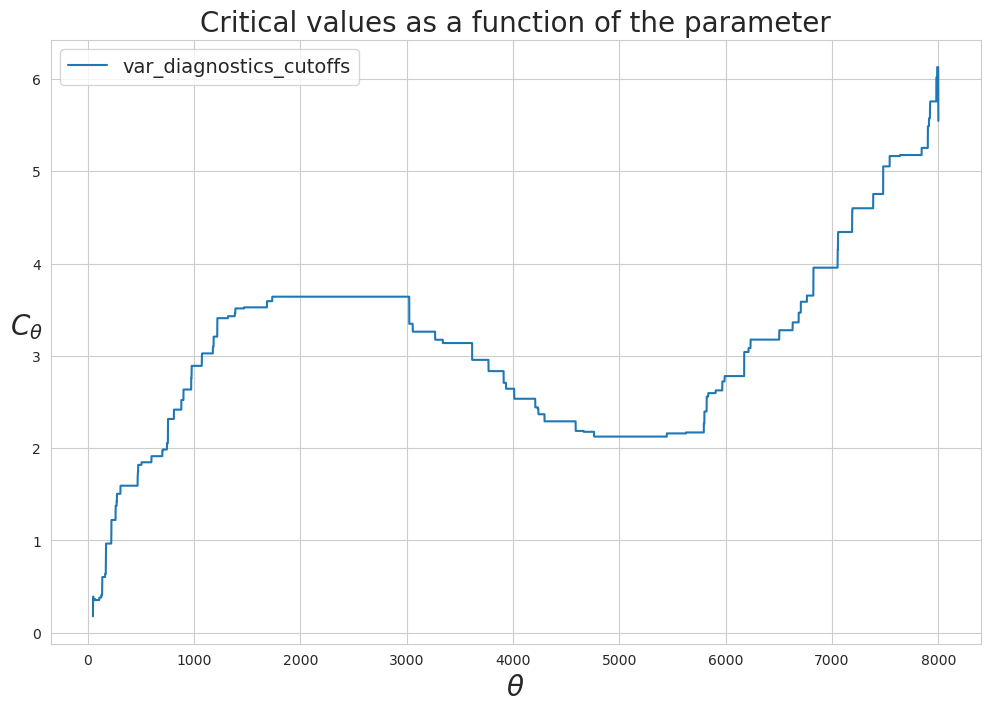

In [74]:
plot_1D_cutoffs(parameters=observed_theta, predicted_cutoffs={'var_diagnostics_cutoffs': var_diagnostics_cutoffs})#, 'novar_diagnostics_cutoffs': novar_diagnostics_cutoffs})

##### Plot

In [75]:
plot_binned(true_params=observed_theta, 
            confidence_sets={'Waldo': var_confidence_sets, 'Waldo - NOVAR': novar_confidence_sets},
            prediction_sets=None,
            coverage_diagnostics={'Waldo': {'statistics': var_diagnostics_stats, 'cutoffs': var_diagnostics_cutoffs}, 
                                  'Waldo - NOVAR': {'statistics': novar_diagnostics_stats, 'cutoffs': novar_diagnostics_cutoffs}},
            n_bins=19, start=np.min(simulator.param_grid), end=np.max(simulator.param_grid), confidence_level=confidence_level, 
            plot_length_quantiles=True, plot_coverage_bins=False,
            save_fig_path=os.path.join(PATH, f'waldo/results/muons/{simulator.observed_d}feats/waldo_var_novar_comparison95.png'),
            is_azure=is_azure)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.90it/s]


fitting GAM
fitting GAM


##### Save results

In [76]:
with open(os.path.join(PATH, 'waldo/results/muons/28feats/waldo_var_results95.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': var_confidence_sets,
                 'statistics_diag': var_diagnostics_stats, 'cutoffs_diag': var_diagnostics_cutoffs}, f)

In [190]:
with open(os.path.join(PATH, 'waldo/results/muons/28feats/waldo_var_results_restricted.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': var_confidence_sets,
                 'statistics_diag': var_diagnostics_stats, 'cutoffs_diag': var_diagnostics_cutoffs}, f)